In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # this includes tensor functions that we can use in backwards pass
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim

# Constructing datasets

In [3]:
# this function does a depth-first search across a matrix of 0s and 1s, 
# looking for a path of 1s between the first and last columns of the matrix
# such a path is called a 'percolation path'

def percolate( mat ):
    """
    Returns True if there is a percolation path of 1s from col 0 col -1 of a matrix of 0s and 1s
    """
    nrows = mat.shape[0]
    ncols = mat.shape[1]
    frontier = set()
    for i in range(0,nrows):
        if mat[i,0]:
            frontier.add( (i,0) )
    explored = set()
    flag = False # this will be returned if the frontier becomes empty without finding a
                 # filled pixel in the right-most column
    while frontier: # frontier evaluates to True in this context if it is non-empty
        r,c = frontier.pop()
        explored.add( (r,c) )
        if r > 0: # North
            if mat[r-1,c]:
                coords = (r-1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c < ncols-1: # East
            if mat[r,c+1]:
                if c+1 == mat.shape[1]-1 : # Hurray, we have percolated to the last column
                    flag = True
                    break
                coords = (r,c+1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if r < nrows-1: # South
            if mat[r+1,c]:
                coords = (r+1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c > 0: # West
            if mat[r,c-1]:
                coords = (r,c-1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
    return flag

In [4]:
def make_percolation_dataset(side=8,threshold=0.42,n_examples=10):
    """
    This function generates an array of random images, in the form needed for pytorch, and 
    then labels them as percolati# ng or not, using the percolate function. Roughly 50% of the
    images will have class 1 (percolating), so the dataset is likely to be reasonably balanced. 
    """
    X_data = (np.random.random([n_examples,side,side,1]) > threshold).astype(float) 
    Y_data = np.zeros([n_examples,1])
    for i in range(0,n_examples):
        if percolate(X_data[i,:,:,0]):
            Y_data[i,0] = 1
    return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]

# the types of the numbers in the tensors need to be float32: the most natural place to do this data conversion
# is in generating the datasets. 

In [71]:
training_set = make_percolation_dataset( n_examples = 1000)
test_set = make_percolation_dataset( n_examples = 1000)

In [41]:
# this calculates the fraction of positive examples in the training set
sum( [ x[1].item() for x in training_set ] ) / len( training_set)

0.493

(<matplotlib.image.AxesImage at 0x7fe5fb21e190>, tensor([0.]))

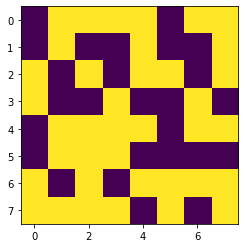

In [42]:
# check that a random element of the training set is correctly labelled
x,y = training_set[401]
plt.imshow(x.numpy().squeeze() ), y  # check a random element of the training set to see it is correct
# we need to squeeze the 

# Define neural net training function

In [8]:
# this function takes a neural-net class as argument, 
# together with the number of epochs, datasets, and batch-size
# I have written it like this to make sure you remember to initialise a new NN 
# (However you can redefine it to take a pre-initialised NN, so that you can repeatedly 
# train a NN with the same weights, as often as you want. )

def define_and_train( NN_class, n_epochs, training_set, test_set, batch_size=32, weight_decay=0.0 ):
    
    trainloader = torch.utils.data.DataLoader( training_set, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader( test_set, batch_size=batch_size, shuffle=True)

    thenet = NN_class()
    optimizer1 = optim.Adam( thenet.parameters(), weight_decay=weight_decay )
    
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs): # number of times to loop over the dataset
        
        total_loss = 0 
        total_correct = 0 
        total_examples = 0 
        n_mini_batches = 0
    
        for i, mini_batch in enumerate( trainloader, 0 ):
            images, labels = mini_batch

            # zero the parameter gradients
            # all the parameters that are being updated are in the optimizer, 
            # so if we zero the gradients of all the tensors in the optimizer, 
            # that is the safest way to zero all the gradients
            optimizer1.zero_grad()

            outputs = thenet(images) # this is the forward pass

            loss = loss_function ( outputs, labels )

            loss.backward() # does the backward pass and computes all gradients

            optimizer1.step() # does one optimisation step

            n_mini_batches += 1 # keep track of number of minibatches, and collect the loss for each minibatch
            total_loss += loss.item() # remember that the loss is a zero-order tensor
            # so that to extract its value, we use .item(), as we cannot index as there are no dimensions

            # keep track of number of examples, and collect number correct in each minibatch
            total_correct += sum( ( outputs > 0.5 ) == ( labels > 0.5 ) ).item()
            total_examples += len( labels )

        # calculate statistics for each epoch and print them. 
        # You can alter this code to accumulate these statistics into lists/vectors and plot them
        epoch_training_accuracy = total_correct / total_examples
        epoch_training_loss = total_loss / n_mini_batches

        epoch_val_accuracy, epoch_val_loss = accuracy_and_loss( thenet, loss_function, testloader )

        print('Epoch %d loss: %.3f acc: %.3f val_loss: %.3f val_acc: %.3f'
              %(epoch+1, epoch_training_loss, epoch_training_accuracy, epoch_val_loss, epoch_val_accuracy   ))
        
        train_loss.append( epoch_training_loss )
        train_acc.append( epoch_training_accuracy )
        val_loss.append( epoch_val_loss )
        val_acc.append( epoch_val_accuracy )
    
    history = { 'train_loss': train_loss, 
                'train_acc': train_acc, 
                'val_loss': val_loss,
                'val_acc': val_acc }
    return ( history, thenet ) 


# Defining accuracy function

In [9]:
# this function calculates the loss and error rate on the validation set
# assuming that the output of the neural net nn is a single prediction probability, from a single sigmoid neuron. 

def accuracy_and_loss( net, loss_function, dataloader ):
    total_correct = 0 
    total_loss = 0.0 
    total_examples = 0 
    n_batches = 0 
    with torch.no_grad():  # we do not neet to compute the gradients when making predictions on the validation set
        for data in dataloader: 
            images, labels = data
            outputs = net(images)
            batch_loss = loss_function(outputs, labels) # this is averaged over the batch
            n_batches += 1
            total_loss += batch_loss.item()
            total_correct += sum( (outputs > 0.5 ) == ( labels > 0.5 ) ).item() # number correct in the minibatch
            total_examples += labels.size(0) # the number of labels, which is just the size of the minibatch 
             
    
    accuracy = total_correct / total_examples
    mean_loss = total_loss / n_batches
    
    return ( accuracy, mean_loss )
    #print( "Accuracy on test set: %d %%" %(100 * correct/total_examples))

# Define Loss function

In [14]:
loss_function = nn.BCELoss() 

# Option 1: Basic convolutional net 

In [15]:
class NN_convolutional1( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [43]:
#Run the model
history_1, net_1 = define_and_train(NN_convolutional1, 100, training_set, test_set, batch_size=32, weight_decay=0.0000 )

Epoch 1 loss: 0.693 acc: 0.494 val_loss: 0.693 val_acc: 0.535
Epoch 2 loss: 0.693 acc: 0.512 val_loss: 0.692 val_acc: 0.540
Epoch 3 loss: 0.687 acc: 0.527 val_loss: 0.687 val_acc: 0.484
Epoch 4 loss: 0.678 acc: 0.549 val_loss: 0.673 val_acc: 0.665
Epoch 5 loss: 0.667 acc: 0.618 val_loss: 0.656 val_acc: 0.663
Epoch 6 loss: 0.636 acc: 0.672 val_loss: 0.653 val_acc: 0.611
Epoch 7 loss: 0.628 acc: 0.678 val_loss: 0.626 val_acc: 0.679
Epoch 8 loss: 0.621 acc: 0.709 val_loss: 0.617 val_acc: 0.697
Epoch 9 loss: 0.599 acc: 0.713 val_loss: 0.602 val_acc: 0.701
Epoch 10 loss: 0.602 acc: 0.708 val_loss: 0.590 val_acc: 0.708
Epoch 11 loss: 0.581 acc: 0.719 val_loss: 0.597 val_acc: 0.704
Epoch 12 loss: 0.572 acc: 0.729 val_loss: 0.586 val_acc: 0.691
Epoch 13 loss: 0.559 acc: 0.746 val_loss: 0.573 val_acc: 0.736
Epoch 14 loss: 0.560 acc: 0.725 val_loss: 0.553 val_acc: 0.732
Epoch 15 loss: 0.521 acc: 0.776 val_loss: 0.540 val_acc: 0.746
Epoch 16 loss: 0.519 acc: 0.763 val_loss: 0.534 val_acc: 0.753
E

# Option 2: Convolutional neural net with dropout

In [64]:
class NN_convolutional2( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional2, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.Conv2d(12,12,3,padding=1),
            nn.Dropout(),
            nn.ReLU(),
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.Dropout(),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [65]:
history_2, net_2 = define_and_train(NN_convolutional2, 100, training_set, test_set, batch_size=32, weight_decay=0.0000 )

Epoch 1 loss: 0.696 acc: 0.493 val_loss: 0.695 val_acc: 0.482
Epoch 2 loss: 0.694 acc: 0.492 val_loss: 0.693 val_acc: 0.484
Epoch 3 loss: 0.691 acc: 0.543 val_loss: 0.688 val_acc: 0.598
Epoch 4 loss: 0.684 acc: 0.591 val_loss: 0.676 val_acc: 0.525
Epoch 5 loss: 0.658 acc: 0.570 val_loss: 0.643 val_acc: 0.628
Epoch 6 loss: 0.629 acc: 0.642 val_loss: 0.606 val_acc: 0.679
Epoch 7 loss: 0.579 acc: 0.700 val_loss: 0.555 val_acc: 0.711
Epoch 8 loss: 0.553 acc: 0.716 val_loss: 0.619 val_acc: 0.664
Epoch 9 loss: 0.534 acc: 0.736 val_loss: 0.552 val_acc: 0.713
Epoch 10 loss: 0.512 acc: 0.743 val_loss: 0.563 val_acc: 0.702
Epoch 11 loss: 0.543 acc: 0.714 val_loss: 0.537 val_acc: 0.728
Epoch 12 loss: 0.502 acc: 0.756 val_loss: 0.529 val_acc: 0.721
Epoch 13 loss: 0.504 acc: 0.758 val_loss: 0.541 val_acc: 0.738
Epoch 14 loss: 0.504 acc: 0.755 val_loss: 0.560 val_acc: 0.733
Epoch 15 loss: 0.503 acc: 0.756 val_loss: 0.517 val_acc: 0.744
Epoch 16 loss: 0.492 acc: 0.767 val_loss: 0.507 val_acc: 0.758
E

Adding dropout makes the performance comparable

# Option 3: Basic Convolutional net with L2 regularisation

In [44]:
history_3, net_3 = define_and_train(NN_convolutional1, 100, training_set, test_set, batch_size=32, weight_decay=1e-5)

Epoch 1 loss: 0.694 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 2 loss: 0.693 acc: 0.508 val_loss: 0.691 val_acc: 0.528
Epoch 3 loss: 0.692 acc: 0.513 val_loss: 0.690 val_acc: 0.523
Epoch 4 loss: 0.689 acc: 0.553 val_loss: 0.692 val_acc: 0.522
Epoch 5 loss: 0.687 acc: 0.576 val_loss: 0.691 val_acc: 0.522
Epoch 6 loss: 0.680 acc: 0.592 val_loss: 0.675 val_acc: 0.576
Epoch 7 loss: 0.655 acc: 0.625 val_loss: 0.638 val_acc: 0.654
Epoch 8 loss: 0.617 acc: 0.659 val_loss: 0.601 val_acc: 0.687
Epoch 9 loss: 0.570 acc: 0.724 val_loss: 0.566 val_acc: 0.705
Epoch 10 loss: 0.558 acc: 0.706 val_loss: 0.557 val_acc: 0.714
Epoch 11 loss: 0.538 acc: 0.706 val_loss: 0.548 val_acc: 0.714
Epoch 12 loss: 0.518 acc: 0.746 val_loss: 0.554 val_acc: 0.721
Epoch 13 loss: 0.517 acc: 0.754 val_loss: 0.565 val_acc: 0.705
Epoch 14 loss: 0.494 acc: 0.758 val_loss: 0.544 val_acc: 0.729
Epoch 15 loss: 0.506 acc: 0.765 val_loss: 0.542 val_acc: 0.729
Epoch 16 loss: 0.489 acc: 0.768 val_loss: 0.508 val_acc: 0.742
E

Comment: L2 regularisation does not seem to increase performance as well

# Option 4:  10 layer Convolutional net with with L2 regularisation 

In [24]:
class NN_convolutional3( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional3, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            #layer 1
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            #layer 2
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #layer 3
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #layer 4
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            
            #layer 5
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            
            #layer 6
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            
            #layer 7
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            
            #layer 8
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            
            #layer 9
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            
            #Output process 
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [27]:
history_4, net_4 = define_and_train(NN_convolutional3, 100, training_set, test_set, batch_size=32, weight_decay= ii)

Epoch 1 loss: 0.693 acc: 0.498 val_loss: 0.692 val_acc: 0.523
Epoch 2 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 3 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 4 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 5 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 6 loss: 0.692 acc: 0.520 val_loss: 0.693 val_acc: 0.523
Epoch 7 loss: 0.693 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 8 loss: 0.693 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 9 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 10 loss: 0.693 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 11 loss: 0.693 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 12 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 13 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 14 loss: 0.692 acc: 0.520 val_loss: 0.693 val_acc: 0.523
Epoch 15 loss: 0.692 acc: 0.520 val_loss: 0.692 val_acc: 0.523
Epoch 16 loss: 0.692 acc: 0.520 val_loss: 0.693 val_acc: 0.523
E

10 layers gets stuck in weird local minima, takes a while to train even on a dataset of 1000 and performance is awful

## Option 6: Basic NN with batch normalisation

In [31]:
class NN_convolutional4( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional4, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.BatchNorm2d(12),
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.BatchNorm2d(2),
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [47]:
history_6, net_6 = define_and_train(NN_convolutional4, 100, training_set, test_set, batch_size=32, weight_decay= 0.00)

Epoch 1 loss: 0.686 acc: 0.545 val_loss: 0.665 val_acc: 0.631
Epoch 2 loss: 0.611 acc: 0.752 val_loss: 0.589 val_acc: 0.703
Epoch 3 loss: 0.498 acc: 0.801 val_loss: 0.524 val_acc: 0.748
Epoch 4 loss: 0.426 acc: 0.812 val_loss: 0.499 val_acc: 0.747
Epoch 5 loss: 0.389 acc: 0.832 val_loss: 0.506 val_acc: 0.745
Epoch 6 loss: 0.345 acc: 0.854 val_loss: 0.493 val_acc: 0.761
Epoch 7 loss: 0.300 acc: 0.884 val_loss: 0.488 val_acc: 0.764
Epoch 8 loss: 0.263 acc: 0.907 val_loss: 0.513 val_acc: 0.765
Epoch 9 loss: 0.227 acc: 0.919 val_loss: 0.506 val_acc: 0.776
Epoch 10 loss: 0.202 acc: 0.931 val_loss: 0.527 val_acc: 0.771
Epoch 11 loss: 0.173 acc: 0.933 val_loss: 0.555 val_acc: 0.764
Epoch 12 loss: 0.154 acc: 0.944 val_loss: 0.546 val_acc: 0.769
Epoch 13 loss: 0.127 acc: 0.961 val_loss: 0.614 val_acc: 0.760
Epoch 14 loss: 0.110 acc: 0.968 val_loss: 0.595 val_acc: 0.766
Epoch 15 loss: 0.095 acc: 0.970 val_loss: 0.695 val_acc: 0.747
Epoch 16 loss: 0.075 acc: 0.979 val_loss: 0.713 val_acc: 0.751
E

Batch norm starts off promisingly but then flattens out! 

## Option 7: 5 layer CNN

In [34]:
class NN_convolutional5( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional5, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            #layer 1
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            #layer 2
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #layer 3
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #layer 4
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #layer 5
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            #Output process 
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [52]:
history_7, net_7 = define_and_train(NN_convolutional5, 100, training_set, test_set, batch_size=32, weight_decay= 0.00)

Epoch 1 loss: 0.694 acc: 0.493 val_loss: 0.695 val_acc: 0.482
Epoch 2 loss: 0.694 acc: 0.493 val_loss: 0.694 val_acc: 0.482
Epoch 3 loss: 0.693 acc: 0.493 val_loss: 0.694 val_acc: 0.482
Epoch 4 loss: 0.693 acc: 0.493 val_loss: 0.694 val_acc: 0.482
Epoch 5 loss: 0.693 acc: 0.493 val_loss: 0.693 val_acc: 0.482
Epoch 6 loss: 0.693 acc: 0.493 val_loss: 0.693 val_acc: 0.482
Epoch 7 loss: 0.693 acc: 0.493 val_loss: 0.693 val_acc: 0.482
Epoch 8 loss: 0.693 acc: 0.497 val_loss: 0.693 val_acc: 0.518
Epoch 9 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 10 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 11 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 12 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 13 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 14 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 15 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
Epoch 16 loss: 0.693 acc: 0.507 val_loss: 0.693 val_acc: 0.518
E

5 layer network without regularisation seems tempermental. Seems to get stuck in local minima more often than not! 

# Option 8: 5 layer CNN with L2 regularisation 

In [54]:
history_8, net_8 = define_and_train(NN_convolutional5, 100, training_set, test_set, batch_size=32, weight_decay= 1e-5)

Epoch 1 loss: 0.698 acc: 0.507 val_loss: 0.694 val_acc: 0.518
Epoch 2 loss: 0.695 acc: 0.507 val_loss: 0.692 val_acc: 0.518
Epoch 3 loss: 0.693 acc: 0.505 val_loss: 0.691 val_acc: 0.518
Epoch 4 loss: 0.689 acc: 0.522 val_loss: 0.692 val_acc: 0.484
Epoch 5 loss: 0.678 acc: 0.572 val_loss: 0.648 val_acc: 0.620
Epoch 6 loss: 0.626 acc: 0.676 val_loss: 0.747 val_acc: 0.601
Epoch 7 loss: 0.631 acc: 0.667 val_loss: 0.638 val_acc: 0.646
Epoch 8 loss: 0.601 acc: 0.719 val_loss: 0.613 val_acc: 0.699
Epoch 9 loss: 0.604 acc: 0.709 val_loss: 0.607 val_acc: 0.722
Epoch 10 loss: 0.599 acc: 0.709 val_loss: 0.591 val_acc: 0.725
Epoch 11 loss: 0.581 acc: 0.744 val_loss: 0.599 val_acc: 0.712
Epoch 12 loss: 0.601 acc: 0.693 val_loss: 0.578 val_acc: 0.742
Epoch 13 loss: 0.558 acc: 0.763 val_loss: 0.574 val_acc: 0.743
Epoch 14 loss: 0.552 acc: 0.781 val_loss: 0.553 val_acc: 0.766
Epoch 15 loss: 0.530 acc: 0.766 val_loss: 0.534 val_acc: 0.772
Epoch 16 loss: 0.517 acc: 0.776 val_loss: 0.587 val_acc: 0.746
E

5 layer with regularisation seems to help, does not get stuck in local minima! 

# Option 9: 5 layer CNN with batch normalisation

In [57]:
class NN_convolutional6( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional6, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.BatchNorm2d(12),
            #layer 1
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            #layer 2
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.BatchNorm2d(12),
            #layer 3
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.BatchNorm2d(12),
            #layer 4
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.BatchNorm2d(12),
            #layer 5
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.BatchNorm2d(2),
            #Output process 
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [75]:
history_9, net_9 = define_and_train(NN_convolutional6, 100, training_set, test_set, batch_size=32, weight_decay= 0.00)

Epoch 1 loss: 0.680 acc: 0.576 val_loss: 0.650 val_acc: 0.667
Epoch 2 loss: 0.564 acc: 0.764 val_loss: 0.535 val_acc: 0.749
Epoch 3 loss: 0.437 acc: 0.828 val_loss: 0.500 val_acc: 0.760
Epoch 4 loss: 0.339 acc: 0.884 val_loss: 0.540 val_acc: 0.744
Epoch 5 loss: 0.232 acc: 0.919 val_loss: 0.565 val_acc: 0.758
Epoch 6 loss: 0.151 acc: 0.954 val_loss: 0.618 val_acc: 0.759
Epoch 7 loss: 0.093 acc: 0.980 val_loss: 0.629 val_acc: 0.765
Epoch 8 loss: 0.066 acc: 0.986 val_loss: 0.687 val_acc: 0.756
Epoch 9 loss: 0.054 acc: 0.987 val_loss: 0.739 val_acc: 0.751
Epoch 10 loss: 0.046 acc: 0.985 val_loss: 0.797 val_acc: 0.772
Epoch 11 loss: 0.042 acc: 0.990 val_loss: 0.763 val_acc: 0.769
Epoch 12 loss: 0.021 acc: 0.997 val_loss: 0.968 val_acc: 0.757
Epoch 13 loss: 0.020 acc: 0.994 val_loss: 0.858 val_acc: 0.753
Epoch 14 loss: 0.042 acc: 0.988 val_loss: 0.888 val_acc: 0.767
Epoch 15 loss: 0.030 acc: 0.991 val_loss: 0.912 val_acc: 0.778
Epoch 16 loss: 0.045 acc: 0.983 val_loss: 1.002 val_acc: 0.765
E

Batch normalistion seems to start off well again but then gets stuck!

In [59]:
history_10, net_10 = define_and_train(NN_convolutional6, 100, training_set, test_set, batch_size=32, weight_decay= 1e-5)

Epoch 1 loss: 0.696 acc: 0.517 val_loss: 0.690 val_acc: 0.526
Epoch 2 loss: 0.616 acc: 0.719 val_loss: 0.643 val_acc: 0.629
Epoch 3 loss: 0.494 acc: 0.798 val_loss: 0.598 val_acc: 0.674
Epoch 4 loss: 0.369 acc: 0.850 val_loss: 0.605 val_acc: 0.705
Epoch 5 loss: 0.258 acc: 0.915 val_loss: 0.664 val_acc: 0.692
Epoch 6 loss: 0.175 acc: 0.958 val_loss: 0.764 val_acc: 0.682
Epoch 7 loss: 0.113 acc: 0.972 val_loss: 0.868 val_acc: 0.675
Epoch 8 loss: 0.088 acc: 0.971 val_loss: 0.875 val_acc: 0.686
Epoch 9 loss: 0.063 acc: 0.986 val_loss: 0.964 val_acc: 0.692
Epoch 10 loss: 0.059 acc: 0.982 val_loss: 1.053 val_acc: 0.648
Epoch 11 loss: 0.059 acc: 0.982 val_loss: 1.113 val_acc: 0.668
Epoch 12 loss: 0.075 acc: 0.975 val_loss: 1.085 val_acc: 0.682
Epoch 13 loss: 0.069 acc: 0.980 val_loss: 1.092 val_acc: 0.691
Epoch 14 loss: 0.032 acc: 0.991 val_loss: 1.144 val_acc: 0.686
Epoch 15 loss: 0.019 acc: 0.997 val_loss: 1.206 val_acc: 0.686
Epoch 16 loss: 0.008 acc: 1.000 val_loss: 1.258 val_acc: 0.678
E

Batch normalisation does not seem to help again!

# Option 11: 5 layer CNN network with dropout 

In [62]:
class NN_convolutional7( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional7, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            #layer 1
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #layer 2
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 3
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 4
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 5
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #Output process 
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [73]:
history_11, net_11 = define_and_train(NN_convolutional7, 100, training_set, test_set, batch_size=32, weight_decay= 1e-5)

Epoch 1 loss: 0.694 acc: 0.492 val_loss: 0.695 val_acc: 0.472
Epoch 2 loss: 0.694 acc: 0.492 val_loss: 0.694 val_acc: 0.472
Epoch 3 loss: 0.693 acc: 0.494 val_loss: 0.694 val_acc: 0.474
Epoch 4 loss: 0.693 acc: 0.477 val_loss: 0.693 val_acc: 0.490
Epoch 5 loss: 0.693 acc: 0.523 val_loss: 0.692 val_acc: 0.532
Epoch 6 loss: 0.682 acc: 0.535 val_loss: 0.651 val_acc: 0.602
Epoch 7 loss: 0.695 acc: 0.539 val_loss: 0.695 val_acc: 0.472
Epoch 8 loss: 0.694 acc: 0.492 val_loss: 0.694 val_acc: 0.472
Epoch 9 loss: 0.694 acc: 0.492 val_loss: 0.694 val_acc: 0.472
Epoch 10 loss: 0.693 acc: 0.492 val_loss: 0.694 val_acc: 0.472
Epoch 11 loss: 0.693 acc: 0.492 val_loss: 0.694 val_acc: 0.472
Epoch 12 loss: 0.693 acc: 0.492 val_loss: 0.693 val_acc: 0.472
Epoch 13 loss: 0.693 acc: 0.490 val_loss: 0.693 val_acc: 0.472
Epoch 14 loss: 0.693 acc: 0.514 val_loss: 0.693 val_acc: 0.524
Epoch 15 loss: 0.693 acc: 0.486 val_loss: 0.693 val_acc: 0.519
Epoch 16 loss: 0.693 acc: 0.532 val_loss: 0.693 val_acc: 0.515
E

Dropout results in better peformance!

# Option 12: 10 layer network with dropout and L2

In [66]:
class NN_convolutional8( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional8, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            #layer 1
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #layer 2
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 3
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 4
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            #layer 5
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            
            #layer 6
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            
            #layer 7
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            
            #layer 8
            nn.Conv2d(12,12,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            
            #layer 9
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Dropout(),
            
            #Output process 
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [72]:
history_12, net_12 = define_and_train(NN_convolutional8, 100, training_set, test_set, batch_size=32, weight_decay= 1e-5)


Epoch 1 loss: 0.695 acc: 0.508 val_loss: 0.691 val_acc: 0.528
Epoch 2 loss: 0.693 acc: 0.508 val_loss: 0.692 val_acc: 0.528
Epoch 3 loss: 0.694 acc: 0.507 val_loss: 0.693 val_acc: 0.498
Epoch 4 loss: 0.694 acc: 0.506 val_loss: 0.693 val_acc: 0.526
Epoch 5 loss: 0.693 acc: 0.505 val_loss: 0.692 val_acc: 0.515
Epoch 6 loss: 0.692 acc: 0.504 val_loss: 0.685 val_acc: 0.497
Epoch 7 loss: 0.685 acc: 0.570 val_loss: 0.685 val_acc: 0.592
Epoch 8 loss: 0.693 acc: 0.510 val_loss: 0.692 val_acc: 0.528
Epoch 9 loss: 0.694 acc: 0.508 val_loss: 0.691 val_acc: 0.528
Epoch 10 loss: 0.693 acc: 0.508 val_loss: 0.692 val_acc: 0.528
Epoch 11 loss: 0.693 acc: 0.508 val_loss: 0.693 val_acc: 0.527
Epoch 12 loss: 0.694 acc: 0.506 val_loss: 0.692 val_acc: 0.526
Epoch 13 loss: 0.693 acc: 0.505 val_loss: 0.692 val_acc: 0.521
Epoch 14 loss: 0.693 acc: 0.509 val_loss: 0.692 val_acc: 0.525
Epoch 15 loss: 0.693 acc: 0.506 val_loss: 0.691 val_acc: 0.526
Epoch 16 loss: 0.693 acc: 0.506 val_loss: 0.692 val_acc: 0.525
E